In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
tqdm.pandas()
%matplotlib inline
sns.set(style='darkgrid')

import missingno as msno
from string import punctuation
from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from google.colab import files
uploaded = files.upload()

Saving women review dataset analysis.csv to women review dataset analysis.csv


In [4]:
data = pd.read_csv('women review dataset analysis.csv',index_col = [0])
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23486 non-null  int64 
 1   Age                      23486 non-null  int64 
 2   Title                    19676 non-null  object
 3   Review Text              22641 non-null  object
 4   Rating                   23486 non-null  int64 
 5   Recommended IND          23486 non-null  int64 
 6   Positive Feedback Count  23486 non-null  int64 
 7   Division Name            23472 non-null  object
 8   Department Name          23472 non-null  object
 9   Class Name               23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


In [6]:
data.describe(include = 'all')

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
count,23486.000000,23486.000000,19676,22641,23486.000000,23486.000000,23486.000000,23472,23472,23472
unique,NaN,NaN,13993,22634,NaN,NaN,NaN,3,6,20
top,NaN,NaN,Love it!,Perfect fit and i've gotten so many compliment...,NaN,NaN,NaN,General,Tops,Dresses
freq,NaN,NaN,136,3,NaN,NaN,NaN,13850,10468,6319
mean,918.118709,43.198544,NaN,NaN,4.196032,0.822362,2.535936,NaN,NaN,NaN
std,203.298980,12.279544,NaN,NaN,1.110031,0.382216,5.702202,NaN,NaN,NaN
min,0.000000,18.000000,NaN,NaN,1.000000,0.000000,0.000000,NaN,NaN,NaN
25%,861.000000,34.000000,NaN,NaN,4.000000,1.000000,0.000000,NaN,NaN,NaN
50%,936.000000,41.000000,NaN,NaN,5.000000,1.000000,1.000000,NaN,NaN,NaN
75%,1078.000000,52.000000,NaN,NaN,5.000000,1.000000,3.000000,NaN,NaN,NaN


# 1. Data Preprocessing

## 1.1 Removing and Renaming Columns

In [7]:
def header_pre(data):
    #Removing Useless Columns
    data.drop(['Clothing ID','Title'],axis = 1,inplace  = True)

    #Renaming the Columns
    new_column = ['age', 'review', 'rating', 'recommended', 
              'pos_feed_count', 'division', 'department', 'class']
    data.columns = new_column

In [8]:
header_pre(data)

In [9]:
data.head()

,age,review,rating,recommended,pos_feed_count,division,department,class
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## 1.2 Data Seperation

In [10]:
text_data,data = data.copy().iloc[:,1:4], data.drop(['review'],axis = 1)

In [11]:
data.head()

,age,rating,recommended,pos_feed_count,division,department,class
0,33,4,1,0,Initmates,Intimate,Intimates
1,34,5,1,4,General,Dresses,Dresses
2,60,3,0,0,General,Dresses,Dresses
3,50,5,1,0,General Petite,Bottoms,Pants
4,47,5,1,6,General,Tops,Blouses


In [12]:
text_data.head()

,review,rating,recommended
0,Absolutely wonderful - silky and sexy and comf...,4,1
1,Love this dress! it's sooo pretty. i happene...,5,1
2,I had such high hopes for this dress and reall...,3,0
3,"I love, love, love this jumpsuit. it's fun, fl...",5,1
4,This shirt is very flattering to all due to th...,5,1


## 1.3 Handling Missing Data

In [13]:
def analyse_msno(data,text_data):
    # Calculating Missing Data
    print('Missing Data in Apparel Data:-\n')
    print(data.isnull().sum())

    print('\n\n\nMissing Data in Text Data:-\n')
    print(text_data.isnull().sum())
    
    # Visualizing Missing Data
    msno.matrix(text_data)
    plt.title('Missing Data in text_data',fontsize = 30)
    plt.plot()   

In [14]:
def handle_msno(data,tex_data):
    analyse_msno(data,text_data)

    #Handling Missing Values
    text_data.dropna(inplace = True)
    text_data.reset_index(drop = True)

    data.dropna(inplace = True)
    data.reset_index(drop = True)

Missing Data in Apparel Data:-

age                0
rating             0
recommended        0
pos_feed_count     0
division          14
department        14
class             14
dtype: int64



Missing Data in Text Data:-

review         845
rating           0
recommended      0
dtype: int64


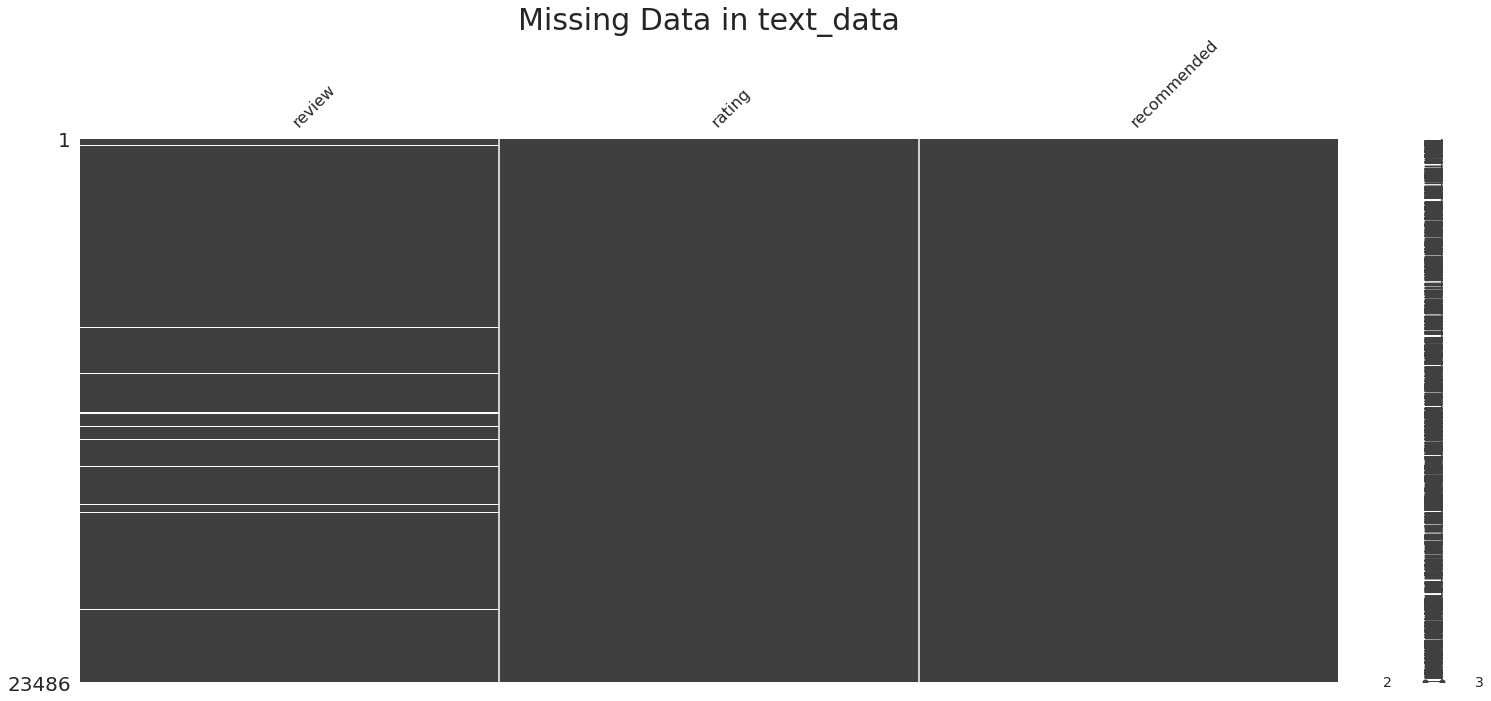

In [15]:
handle_msno(data,text_data)

## 1.4. Pre Processing text_data

In [16]:
#Seperating Reviews and Target Columns
reviews = text_data['review']
targets = text_data[['rating','recommended']]

In [17]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

def preprocess(df):
    stop = set(stopwords.words('english'))
    X = []

    for sent in df:
        text = re.sub(r'@\w+ | http', '', sent)
        text = re.sub(r'[^a-zA-Z ]+', ' ', text).strip()
        token = word_tokenize(text.lower())
        token = [i for i in token if i not in stop]
        text = ' '.join(token)
        X.append(text)
    return X

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [18]:
tf = TfidfVectorizer(min_df = 0.01, max_df=0.8)
new_reviews = tf.fit_transform(preprocess(reviews)).toarray()

In [19]:
new_reviews = pd.DataFrame(new_reviews,columns=tf.get_feature_names())

In [ ]:
new_reviews

,able,absolutely,across,actually,add,adds,adorable,agree,almost,already,also,although,always,amazing,ankle,another,anything,area,arm,arms,around,arrived,athletic,available,away,back,bad,baggy,based,beautiful,beautifully,belt,best,better,big,bigger,bit,black,blouse,blue,...,vibrant,waist,waisted,wait,want,wanted,wardrobe,warm,wash,washed,way,wear,wearing,weather,wedding,weight,weird,well,went,white,wide,winter,wish,without,wonderful,wore,work,worked,works,worn,worth,would,xl,xs,xxs,year,years,yellow,yet,zipper
0,0.000000,0.576845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.710553,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.263710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.174931,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.146936,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.225721
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.185367,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.167001,0.0,0.0,0.000000,0.0,0.0,0.208174,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22636,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
22637,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
22638,0.312821,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.187909,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.340418,0.0,0.0,0.000000

# Exploratory Data Analysis

In [20]:
data.corr()

,age,rating,recommended,pos_feed_count
age,1.000000,0.026967,0.030712,0.043049
rating,0.026967,1.000000,0.792311,-0.064820
recommended,0.030712,0.792311,1.000000,-0.068954
pos_feed_count,0.043049,-0.064820,-0.068954,1.000000


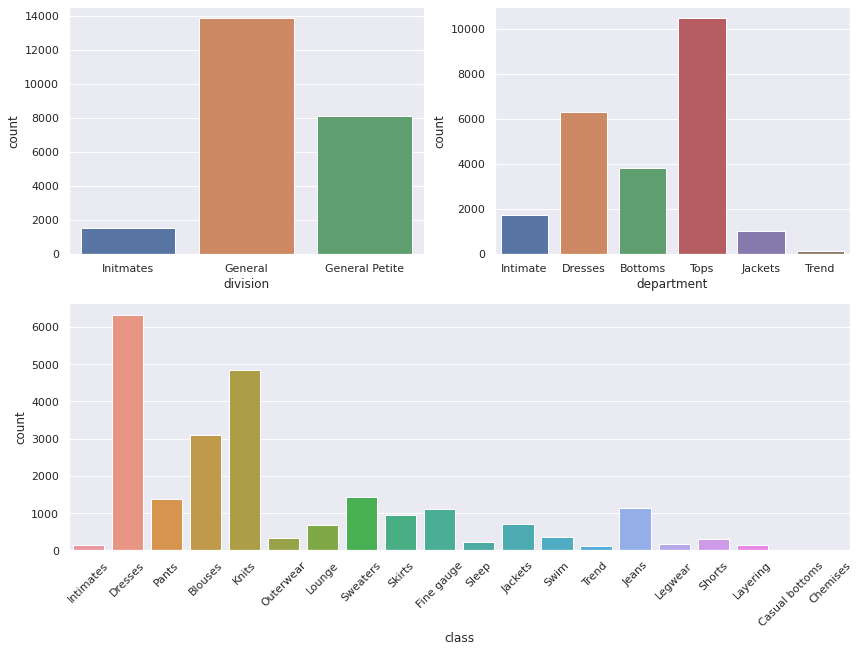

In [21]:
plt.figure(figsize=(14,10))
a1 = plt.subplot2grid((2,2),(0,0))
a1 = sns.countplot(x = data['division'])

a2 = plt.subplot2grid((2,2),(0,1))
a2 = sns.countplot(x = data['department'])

a3 = plt.subplot2grid((2,2),(1,0), colspan = 2)
a3 = sns.countplot(x = data['class'])
a3 = plt.xticks(rotation = 45)

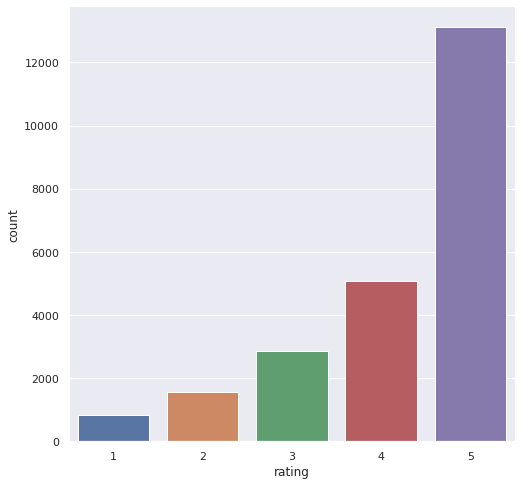

In [22]:
plt.figure(figsize=(8,8))
sns.countplot(x = data['rating'])

### From the above plot it can be said that most customers are satisfied with the product.

(array([ 646., 1770., 3647., 4562., 3204., 3316., 2117., 2000., 1326.,
         555.,  190.,   58.,   61.,   15.,    5.]),
 array([18. , 23.4, 28.8, 34.2, 39.6, 45. , 50.4, 55.8, 61.2, 66.6, 72. ,
        77.4, 82.8, 88.2, 93.6, 99. ]),
 <a list of 15 Patch objects>)

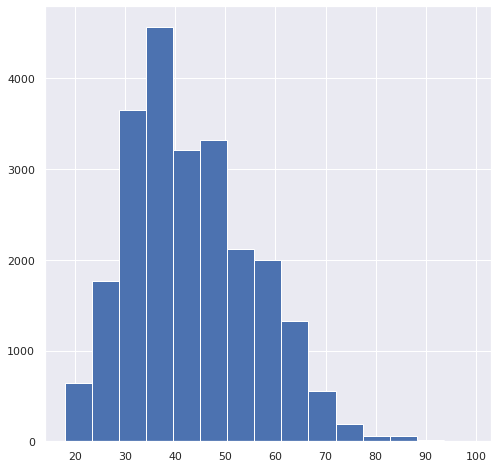

In [23]:
plt.figure(figsize=(8,8))
plt.hist(data['age'],bins = 15)

### From the above graph its pretty clear that the most review age group is between 35 - 39 and the most actively reviewing age group is 24 - 66

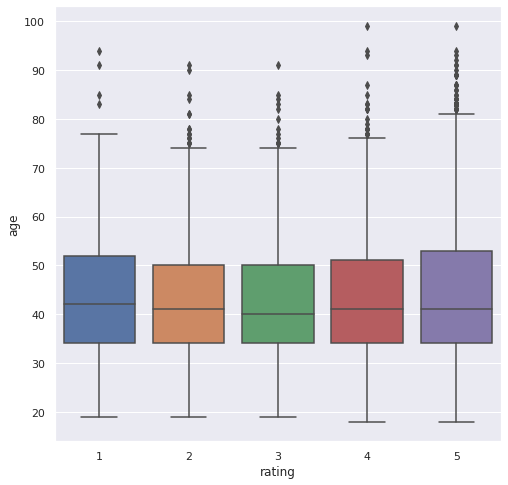

In [24]:
plt.figure(figsize=(8,8))
sns.boxplot(x = 'rating', y = 'age', data = data)

# Predictive Analysis

In [27]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [28]:
targets['rating'] = targets['rating'].apply(lambda x: 2 if x>=4 else (1 if x==3 else 0))

In [29]:
trainX,testX,trainY,testY = train_test_split(new_reviews,targets['rating'],random_state = 0)

In [30]:
class_freq = trainY.value_counts()

weights = {}
for i in range(3):
    weights[i] = 13156/class_freq[i]
weights

{0: 7.483503981797497, 1: 6.367860600193611, 2: 1.0}

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import CategoricalCrossentropy

In [32]:
model = Sequential()

model.add(Dense(64, activation = 'relu',input_shape = trainX.shape))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

In [33]:
model.compile(optimizer = 'adam', loss = CategoricalCrossentropy(), metrics=['accuracy'])

In [34]:
model.fit(trainX, pd.get_dummies(trainY), epochs=20, batch_size=32, class_weight = weights)

Epoch 1/20
531/531 [==============================] - 1s 2ms/step - loss: 2.2449 - accuracy: 0.7404
Epoch 2/20
531/531 [==============================] - 1s 2ms/step - loss: 1.6474 - accuracy: 0.7580
Epoch 3/20
531/531 [==============================] - 1s 2ms/step - loss: 1.5586 - accuracy: 0.7619
Epoch 4/20
531/531 [==============================] - 1s 2ms/step - loss: 1.4099 - accuracy: 0.7820
Epoch 5/20
531/531 [==============================] - 1s 1ms/step - loss: 1.2856 - accuracy: 0.7901
Epoch 6/20
531/531 [==============================] - 1s 1ms/step - loss: 1.1185 - accuracy: 0.8187
Epoch 7/20
531/531 [==============================] - 1s 1ms/step - loss: 0.9060 - accuracy: 0.8556
Epoch 8/20
531/531 [==============================] - 1s 2ms/step - loss: 0.6903 - accuracy: 0.8784
Epoch 9/20
531/531 [==============================] - 1s 2ms/step - loss: 0.5146 - accuracy: 0.9009
Epoch 10/20
531/531 [==============================] - 1s 1ms/step - loss: 0.3885 - accuracy: 0.9178

In [35]:
print(classification_report(testY, model.predict(testX).argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.41      0.44      0.43       612
           1       0.34      0.29      0.31       757
           2       0.88      0.90      0.89      4292

    accuracy                           0.76      5661
   macro avg       0.54      0.54      0.54      5661
weighted avg       0.76      0.76      0.76      5661

